<a href="https://colab.research.google.com/github/millicentserwaa/Codes/blob/master/Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SYNTHETIC DATA APPROACH

In [4]:
import numpy as np
import pandas as pd

np.random.seed(42)

def generate_synthetic_af_dataset(n_normal=3000, n_af=3000):
    all_features = []
    all_labels = []

    print(f"Generating {n_normal} Normal samples...")

    for i in range(n_normal):
        base_rr = np.random.normal(850, 100)
        rr_std = max(20, np.random.normal(40, 10))  # Ensure positive

        n_beats = 30
        rr_intervals = np.random.normal(base_rr, rr_std, n_beats)
        rr_intervals = np.clip(rr_intervals, 400, 1500)

        successive_diffs = np.diff(rr_intervals)

        features = {
            'mean_rr': float(np.mean(rr_intervals)),
            'std_rr': float(np.std(rr_intervals)),
            'cv': float(np.std(rr_intervals) / np.mean(rr_intervals)),
            'mean_hr': float(60000 / np.mean(rr_intervals)),
            'rmssd': float(np.sqrt(np.mean(successive_diffs ** 2))),
            'pnn50': float(np.sum(np.abs(successive_diffs) > 50) / len(successive_diffs) * 100),
        }

        all_features.append(features)
        all_labels.append(0)

    print(f"Generating {n_af} AF samples...")

    for i in range(n_af):
        base_rr = np.random.normal(750, 150)
        rr_std = max(50, np.random.normal(180, 50))  # Ensure positive and minimum 50

        n_beats = 30
        rr_intervals = np.random.normal(base_rr, rr_std, n_beats)
        rr_intervals += np.random.normal(0, 80, n_beats)
        rr_intervals = np.clip(rr_intervals, 300, 1800)

        successive_diffs = np.diff(rr_intervals)

        features = {
            'mean_rr': float(np.mean(rr_intervals)),
            'std_rr': float(np.std(rr_intervals)),
            'cv': float(np.std(rr_intervals) / np.mean(rr_intervals)),
            'mean_hr': float(60000 / np.mean(rr_intervals)),
            'rmssd': float(np.sqrt(np.mean(successive_diffs ** 2))),
            'pnn50': float(np.sum(np.abs(successive_diffs) > 50) / len(successive_diffs) * 100),
        }

        all_features.append(features)
        all_labels.append(1)

    df = pd.DataFrame(all_features)
    return df.values, np.array(all_labels), df.columns.tolist()

X, y, feature_names = generate_synthetic_af_dataset()
print(f"\nDataset ready: {len(y)} samples, {len(feature_names)} features")
print(f"Normal: {np.sum(y==0)}, AF: {np.sum(y==1)}")

Generating 3000 Normal samples...
Generating 3000 AF samples...

Dataset ready: 6000 samples, 6 features
Normal: 3000, AF: 3000


TRAINING ML MODELS

PREPROCESSING DATA...

Training set: 4800 samples
Test set: 1200 samples

TRAINING MODELS...

[1/4] Training Random Forest...
[2/4] Training Gradient Boosting...
[3/4] Training SVM...
[4/4] Training Logistic Regression...

MODEL EVALUATION:

Random Forest:
  Accuracy:    100.0%
  AUC:         1.000
  Sensitivity: 100.0%
  Specificity: 100.0%

Gradient Boosting:
  Accuracy:    99.9%
  AUC:         0.999
  Sensitivity: 99.8%
  Specificity: 100.0%

SVM:
  Accuracy:    100.0%
  AUC:         1.000
  Sensitivity: 100.0%
  Specificity: 100.0%

Logistic Regression:
  Accuracy:    100.0%
  AUC:         1.000
  Sensitivity: 100.0%
  Specificity: 100.0%



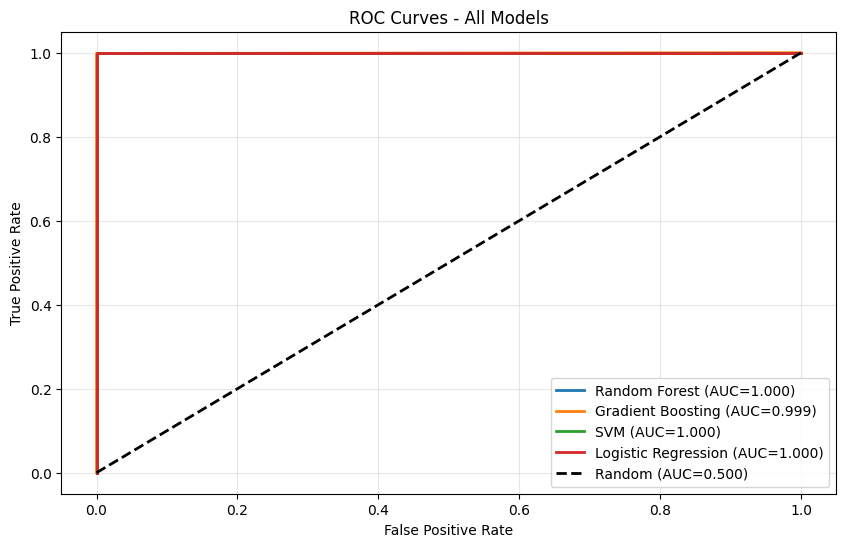

BEST MODEL: Random Forest
AUC: 1.0000


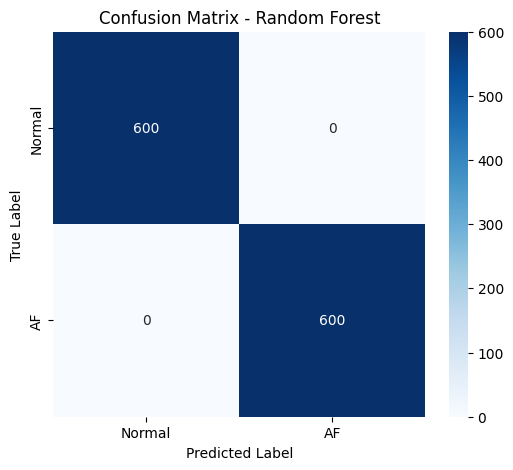


Model and scaler saved!


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

print("PREPROCESSING DATA...\n")

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples\n")

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("TRAINING MODELS...\n")

models = {}

# Model 1: Random Forest
print("[1/4] Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)
models['Random Forest'] = rf_model

# Model 2: Gradient Boosting
print("[2/4] Training Gradient Boosting...")
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42
)
gb_model.fit(X_train_scaled, y_train)
models['Gradient Boosting'] = gb_model

# Model 3: SVM
print("[3/4] Training SVM...")
svm_model = SVC(
    kernel='rbf',
    probability=True,
    random_state=42
)
svm_model.fit(X_train_scaled, y_train)
models['SVM'] = svm_model

# Model 4: Logistic Regression
print("[4/4] Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)
models['Logistic Regression'] = lr_model

print("\nMODEL EVALUATION:\n")

results = {}

for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    print(f"{name}:")
    print(f"  Accuracy:    {accuracy:.1%}")
    print(f"  AUC:         {auc:.3f}")
    print(f"  Sensitivity: {sensitivity:.1%}")
    print(f"  Specificity: {specificity:.1%}")
    print()

    results[name] = {
        'accuracy': accuracy,
        'auc': auc,
        'y_pred_proba': y_pred_proba,
        'confusion_matrix': cm
    }

# Plot ROC curves
plt.figure(figsize=(10, 6))

for name in models.keys():
    fpr, tpr, _ = roc_curve(y_test, results[name]['y_pred_proba'])
    plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC={results[name]["auc"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random (AUC=0.500)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - All Models')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Select best model
best_model_name = max(results, key=lambda k: results[k]['auc'])
best_model = models[best_model_name]

print(f"BEST MODEL: {best_model_name}")
print(f"AUC: {results[best_model_name]['auc']:.4f}")

# Show confusion matrix for best model
cm = results[best_model_name]['confusion_matrix']
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'AF'],
            yticklabels=['Normal', 'AF'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Save best model and scaler
import pickle

with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("\nModel and scaler saved!")

INRODUCTING NOISE TO DATA

Generating REALISTIC Normal samples with noise...
Generating REALISTIC AF samples with variation...

Dataset ready: 6000 samples, 6 features

CV Statistics:
Normal - Mean: 0.058, Std: 0.030
AF     - Mean: 0.244, Std: 0.090
Overlap: 0.200 (Normal max) vs 0.062 (AF min)


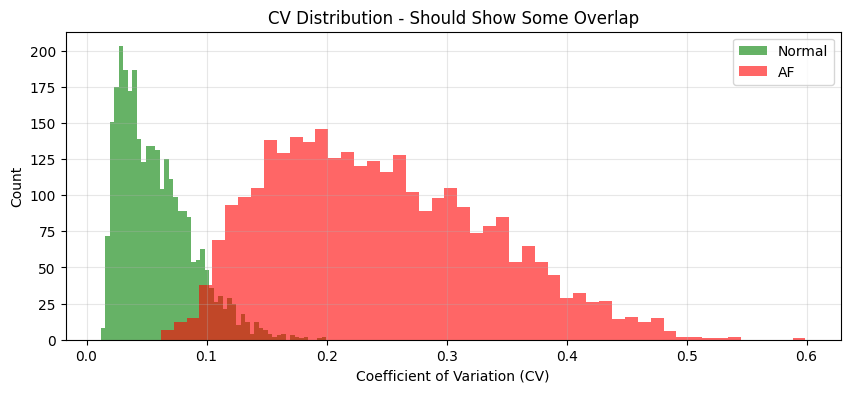


You should see overlap between the distributions now!


In [6]:
import numpy as np
import pandas as pd

np.random.seed(42)

def generate_realistic_af_dataset(n_normal=3000, n_af=3000):
    all_features = []
    all_labels = []

    print("Generating REALISTIC Normal samples with noise...")

    for i in range(n_normal):
        # Normal: Some variety - athletic vs sedentary, young vs old
        if np.random.rand() < 0.3:
            # 30% are "athletic" - very regular
            base_rr = np.random.normal(900, 120)
            rr_std = max(15, np.random.normal(25, 8))
        elif np.random.rand() < 0.5:
            # 35% are "average"
            base_rr = np.random.normal(850, 100)
            rr_std = max(20, np.random.normal(45, 15))
        else:
            # 35% are "irregular normal" (borderline)
            base_rr = np.random.normal(820, 110)
            rr_std = max(30, np.random.normal(70, 20))  # Higher variation but still normal

        n_beats = 30
        rr_intervals = np.random.normal(base_rr, rr_std, n_beats)

        # Add respiratory variation
        respiratory = 15 * np.sin(2 * np.pi * np.random.uniform(0.2, 0.35) * np.arange(n_beats))
        rr_intervals += respiratory

        rr_intervals = np.clip(rr_intervals, 400, 1500)
        successive_diffs = np.diff(rr_intervals)

        features = {
            'mean_rr': float(np.mean(rr_intervals)),
            'std_rr': float(np.std(rr_intervals)),
            'cv': float(np.std(rr_intervals) / np.mean(rr_intervals)),
            'mean_hr': float(60000 / np.mean(rr_intervals)),
            'rmssd': float(np.sqrt(np.mean(successive_diffs ** 2))),
            'pnn50': float(np.sum(np.abs(successive_diffs) > 50) / len(successive_diffs) * 100),
        }

        all_features.append(features)
        all_labels.append(0)

    print("Generating REALISTIC AF samples with variation...")

    for i in range(n_af):
        # AF: Some variety - paroxysmal AF (less chaotic) vs persistent AF (very chaotic)
        if np.random.rand() < 0.4:
            # 40% are "organized AF" - still irregular but less chaotic
            base_rr = np.random.normal(780, 130)
            rr_std = max(60, np.random.normal(120, 35))
            extra_chaos = 40
        else:
            # 60% are "chaotic AF" - very irregular
            base_rr = np.random.normal(720, 160)
            rr_std = max(80, np.random.normal(200, 60))
            extra_chaos = 90

        n_beats = 30
        rr_intervals = np.random.normal(base_rr, rr_std, n_beats)
        rr_intervals += np.random.normal(0, extra_chaos, n_beats)

        # Add random jumps
        for _ in range(np.random.randint(2, 6)):
            idx = np.random.randint(0, n_beats)
            rr_intervals[idx] += np.random.choice([-1, 1]) * np.random.uniform(80, 200)

        rr_intervals = np.clip(rr_intervals, 300, 1800)
        successive_diffs = np.diff(rr_intervals)

        features = {
            'mean_rr': float(np.mean(rr_intervals)),
            'std_rr': float(np.std(rr_intervals)),
            'cv': float(np.std(rr_intervals) / np.mean(rr_intervals)),
            'mean_hr': float(60000 / np.mean(rr_intervals)),
            'rmssd': float(np.sqrt(np.mean(successive_diffs ** 2))),
            'pnn50': float(np.sum(np.abs(successive_diffs) > 50) / len(successive_diffs) * 100),
        }

        all_features.append(features)
        all_labels.append(1)

    df = pd.DataFrame(all_features)
    return df.values, np.array(all_labels), df.columns.tolist()

# Generate new realistic dataset
X, y, feature_names = generate_realistic_af_dataset()

print(f"\nDataset ready: {len(y)} samples, {len(feature_names)} features")

# Check CV distribution
cv_idx = feature_names.index('cv')
print(f"\nCV Statistics:")
print(f"Normal - Mean: {X[y==0, cv_idx].mean():.3f}, Std: {X[y==0, cv_idx].std():.3f}")
print(f"AF     - Mean: {X[y==1, cv_idx].mean():.3f}, Std: {X[y==1, cv_idx].std():.3f}")
print(f"Overlap: {X[y==0, cv_idx].max():.3f} (Normal max) vs {X[y==1, cv_idx].min():.3f} (AF min)")

# Visualize overlap
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.hist(X[y==0, cv_idx], bins=50, alpha=0.6, label='Normal', color='green')
plt.hist(X[y==1, cv_idx], bins=50, alpha=0.6, label='AF', color='red')
plt.xlabel('Coefficient of Variation (CV)')
plt.ylabel('Count')
plt.title('CV Distribution - Should Show Some Overlap')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print("\nYou should see overlap between the distributions now!")

TRAIN MODELS

PREPROCESSING DATA...

Training set: 4800 samples
Test set: 1200 samples

TRAINING MODELS...

[1/4] Training Random Forest...
[2/4] Training Gradient Boosting...
[3/4] Training SVM...
[4/4] Training Logistic Regression...

MODEL EVALUATION:

Random Forest:
  Accuracy:    95.3%
  AUC:         0.993
  Sensitivity: 95.8%
  Specificity: 94.8%

Gradient Boosting:
  Accuracy:    95.1%
  AUC:         0.993
  Sensitivity: 95.0%
  Specificity: 95.2%

SVM:
  Accuracy:    95.2%
  AUC:         0.991
  Sensitivity: 94.3%
  Specificity: 96.0%

Logistic Regression:
  Accuracy:    95.0%
  AUC:         0.994
  Sensitivity: 94.0%
  Specificity: 96.0%



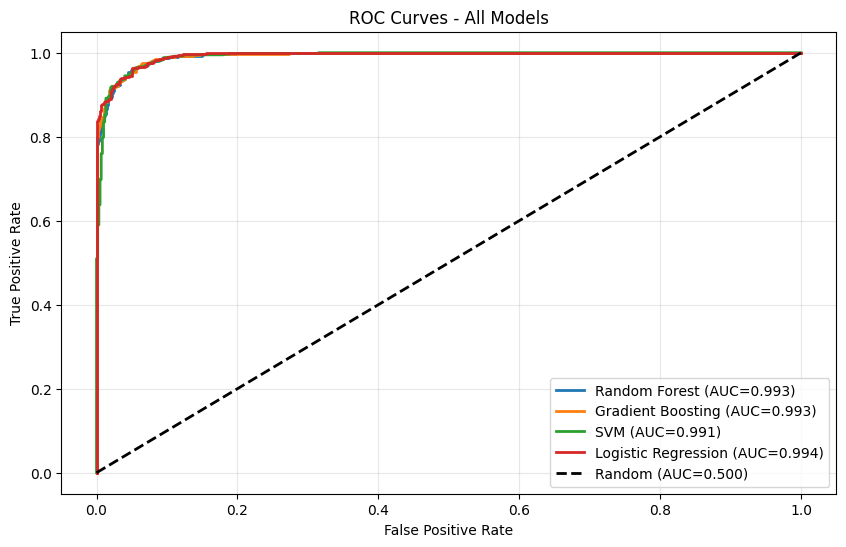


BEST MODEL (by sensitivity): Random Forest
Sensitivity: 95.8%
AUC: 0.993


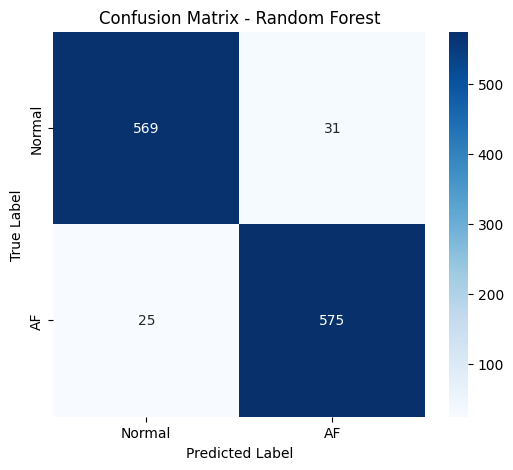


Model and scaler saved!


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

print("PREPROCESSING DATA...\n")

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples\n")

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("TRAINING MODELS...\n")

models = {}

# Model 1: Random Forest
print("[1/4] Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)
models['Random Forest'] = rf_model

# Model 2: Gradient Boosting
print("[2/4] Training Gradient Boosting...")
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42
)
gb_model.fit(X_train_scaled, y_train)
models['Gradient Boosting'] = gb_model

# Model 3: SVM
print("[3/4] Training SVM...")
svm_model = SVC(
    kernel='rbf',
    probability=True,
    random_state=42
)
svm_model.fit(X_train_scaled, y_train)
models['SVM'] = svm_model

# Model 4: Logistic Regression
print("[4/4] Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)
models['Logistic Regression'] = lr_model

print("\nMODEL EVALUATION:\n")

results = {}

for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    print(f"{name}:")
    print(f"  Accuracy:    {accuracy:.1%}")
    print(f"  AUC:         {auc:.3f}")
    print(f"  Sensitivity: {sensitivity:.1%}")
    print(f"  Specificity: {specificity:.1%}")
    print()

    results[name] = {
        'accuracy': accuracy,
        'auc': auc,
        'y_pred_proba': y_pred_proba,
        'confusion_matrix': cm
    }

# Plot ROC curves
plt.figure(figsize=(10, 6))

for name in models.keys():
    fpr, tpr, _ = roc_curve(y_test, results[name]['y_pred_proba'])
    plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC={results[name]["auc"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random (AUC=0.500)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - All Models')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Find model with highest sensitivity (most important for AF screening)
best_model_name = max(results, key=lambda k: results[k]['confusion_matrix'][1,1] /
                                              (results[k]['confusion_matrix'][1,1] +
                                               results[k]['confusion_matrix'][1,0]))

print(f"\nBEST MODEL (by sensitivity): {best_model_name}")
print(f"Sensitivity: {results[best_model_name]['confusion_matrix'][1,1] / (results[best_model_name]['confusion_matrix'][1,1] + results[best_model_name]['confusion_matrix'][1,0]):.1%}")
print(f"AUC: {results[best_model_name]['auc']:.3f}")

# Show confusion matrix for best model
cm = results[best_model_name]['confusion_matrix']
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'AF'],
            yticklabels=['Normal', 'AF'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Save best model and scaler
import pickle

with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("\nModel and scaler saved!")

Converting the model to tensorflow lite

CONVERTING RANDOM FOREST TO NEURAL NETWORK

Step 1: Getting Random Forest predictions on training data...
Random Forest training accuracy: 95.9%

Step 2: Training Neural Network to mimic Random Forest...
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Neural Network accuracy: 94.8%
Accuracy difference: 0.6%
Neural Network successfully mimics Random Forest!


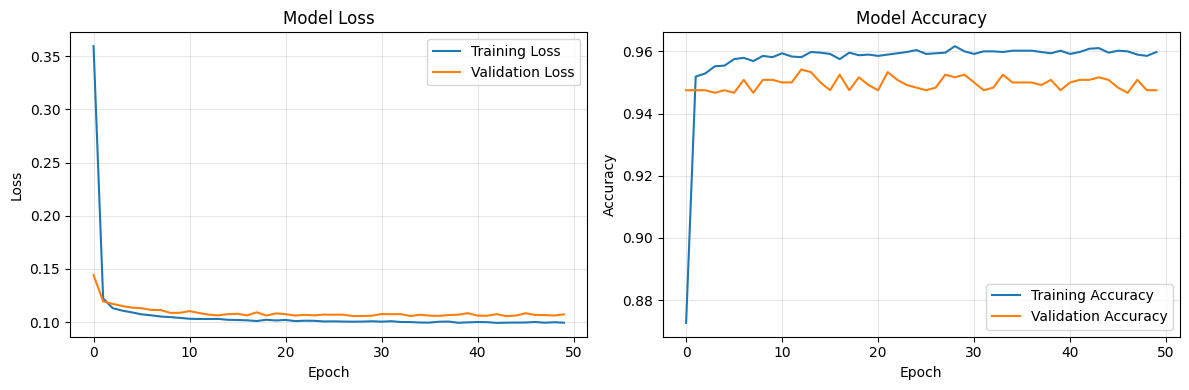


Neural Network trained successfully!


In [9]:
#Random Forest can't directly convert to TFLite, so we train a Neural Network to mimic it

import tensorflow as tf
from tensorflow import keras

print("CONVERTING RANDOM FOREST TO NEURAL NETWORK\n")

# Use Random Forest to label all training data
print("Step 1: Getting Random Forest predictions on training data...")
rf_predictions = best_model.predict(X_train_scaled)
rf_probabilities = best_model.predict_proba(X_train_scaled)

print(f"Random Forest training accuracy: {accuracy_score(y_train, rf_predictions):.1%}")

# Train Neural Network to mimic Random Forest
print("\nStep 2: Training Neural Network to mimic Random Forest...")

nn_model = keras.Sequential([
    keras.layers.Input(shape=(6,)),  # 6 features
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

nn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = nn_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=50,
    batch_size=32,
    verbose=0
)

# Evaluate Neural Network
nn_predictions = (nn_model.predict(X_test_scaled) > 0.5).astype(int).flatten()
nn_accuracy = accuracy_score(y_test, nn_predictions)

print(f"Neural Network accuracy: {nn_accuracy:.1%}")
print(f"Accuracy difference: {abs(nn_accuracy - results['Random Forest']['accuracy']):.1%}")

if abs(nn_accuracy - results['Random Forest']['accuracy']) < 0.05:
    print("Neural Network successfully mimics Random Forest!")
else:
    print("Warning: Neural Network performance differs from Random Forest")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nNeural Network trained successfully!")

In [10]:
print("\nCONVERTING TO TENSORFLOW LITE\n")

# Save full Keras model first
nn_model.save('af_detection_model.h5')
print("Saved: af_detection_model.h5")

# Convert to TensorFlow Lite with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(nn_model)

# Enable quantization (reduces size for ESP32)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Representative dataset for quantization calibration
def representative_dataset():
    for i in range(100):
        yield [X_train_scaled[i:i+1].astype(np.float32)]

converter.representative_dataset = representative_dataset

# Convert
tflite_model = converter.convert()

# Save TFLite model
with open('af_detection_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Saved: af_detection_model.tflite")

# Check file sizes
import os

h5_size = os.path.getsize('af_detection_model.h5')
tflite_size = os.path.getsize('af_detection_model.tflite')

print(f"\nModel Sizes:")
print(f"  Keras (.h5):     {h5_size / 1024:.2f} KB")
print(f"  TFLite (.tflite): {tflite_size / 1024:.2f} KB")
print(f"  Compression:      {(1 - tflite_size/h5_size) * 100:.1f}%")

if tflite_size < 50000:
    print(f"\n  Model fits on ESP32 (has 520 KB RAM)")
else:
    print(f"\n  Warning: Model might be too large for ESP32")


CONVERTING TO TENSORFLOW LITE

Saved: af_detection_model.h5
Saved artifact at '/tmp/tmplpybq65c'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 6), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  134375384135056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134375384136208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134375384134864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134375384132560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134375384136784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134375384133712: TensorSpec(shape=(), dtype=tf.resource, name=None)
Saved: af_detection_model.tflite

Model Sizes:
  Keras (.h5):     35.95 KB
  TFLite (.tflite): 4.77 KB
  Compression:      86.7%

  Model fits on ESP32 (has 520 KB RAM)


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [11]:
print("\nTESTING TENSORFLOW LITE MODEL\n")

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path='af_detection_model.tflite')
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Model Info:")
print(f"  Input shape:  {input_details[0]['shape']}")
print(f"  Input type:   {input_details[0]['dtype']}")
print(f"  Output shape: {output_details[0]['shape']}")
print(f"  Output type:  {output_details[0]['dtype']}")

# Test on all test samples
tflite_predictions = []

for i in range(len(X_test_scaled)):
    # Set input
    interpreter.set_tensor(input_details[0]['index'], X_test_scaled[i:i+1].astype(np.float32))

    # Run inference
    interpreter.invoke()

    # Get output
    output = interpreter.get_tensor(output_details[0]['index'])
    tflite_predictions.append(output[0][0])

tflite_predictions = np.array(tflite_predictions)
tflite_pred_binary = (tflite_predictions > 0.5).astype(int)

# Compare accuracies
keras_pred = nn_model.predict(X_test_scaled, verbose=0)
keras_pred_binary = (keras_pred > 0.5).astype(int).flatten()

keras_accuracy = accuracy_score(y_test, keras_pred_binary)
tflite_accuracy = accuracy_score(y_test, tflite_pred_binary)

print(f"\nAccuracy Comparison:")
print(f"  Keras model:  {keras_accuracy:.1%}")
print(f"  TFLite model: {tflite_accuracy:.1%}")
print(f"  Difference:   {abs(keras_accuracy - tflite_accuracy):.1%}")

if abs(keras_accuracy - tflite_accuracy) < 0.02:
    print("\n  TFLite quantization successful (minimal accuracy loss)")
else:
    print("\n  Warning: Quantization caused significant accuracy loss")

# Test single prediction
print("\nTest Single Prediction:")
test_sample = X_test_scaled[0:1]
true_label = "AF" if y_test[0] == 1 else "Normal"

interpreter.set_tensor(input_details[0]['index'], test_sample.astype(np.float32))
interpreter.invoke()
output = interpreter.get_tensor(output_details[0]['index'])

prediction = "AF" if output[0][0] > 0.5 else "Normal"
confidence = output[0][0] if output[0][0] > 0.5 else 1 - output[0][0]

print(f"  True label:     {true_label}")
print(f"  Prediction:     {prediction}")
print(f"  Confidence:     {confidence:.1%}")
print(f"  Raw output:     {output[0][0]:.4f}")


TESTING TENSORFLOW LITE MODEL

Model Info:
  Input shape:  [1 6]
  Input type:   <class 'numpy.float32'>
  Output shape: [1 1]
  Output type:  <class 'numpy.float32'>


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)



Accuracy Comparison:
  Keras model:  94.8%
  TFLite model: 94.7%
  Difference:   0.1%

  TFLite quantization successful (minimal accuracy loss)

Test Single Prediction:
  True label:     Normal
  Prediction:     Normal
  Confidence:     100.0%
  Raw output:     0.0000


In [12]:
print("\nSAVING PREPROCESSING PARAMETERS\n")

# Extract scaler parameters
scaler_mean = scaler.mean_
scaler_scale = scaler.scale_

# Save to text file for ESP32
with open('scaler_params.txt', 'w') as f:
    f.write("// Scaler parameters (mean and scale for each feature)\n")
    f.write("// Features: mean_rr, std_rr, cv, mean_hr, rmssd, pnn50\n\n")

    f.write("const float SCALER_MEAN[6] = {\n")
    for i, val in enumerate(scaler_mean):
        f.write(f"  {val:.6f}{',' if i < 5 else ''} // {feature_names[i]}\n")
    f.write("};\n\n")

    f.write("const float SCALER_SCALE[6] = {\n")
    for i, val in enumerate(scaler_scale):
        f.write(f"  {val:.6f}{',' if i < 5 else ''} // {feature_names[i]}\n")
    f.write("};\n")

print("Saved: scaler_params.txt")

# Also save feature names
with open('feature_info.txt', 'w') as f:
    f.write("Feature Order (must match in ESP32 code):\n\n")
    for i, name in enumerate(feature_names):
        f.write(f"{i}: {name}\n")

print("Saved: feature_info.txt")

# Display scaler parameters
print("\nScaler Parameters:")
for i, name in enumerate(feature_names):
    print(f"  {name:10s}: mean={scaler_mean[i]:8.2f}, scale={scaler_scale[i]:8.2f}")


SAVING PREPROCESSING PARAMETERS

Saved: scaler_params.txt
Saved: feature_info.txt

Scaler Parameters:
  mean_rr   : mean=  806.49, scale=  142.98
  std_rr    : mean=  112.94, scale=   78.27
  cv        : mean=    0.15, scale=    0.11
  mean_hr   : mean=   77.08, scale=   15.77
  rmssd     : mean=  162.39, scale=  114.04
  pnn50     : mean=   62.27, scale=   26.45


In [13]:
from google.colab import files

print("\nDOWNLOADING FILES FOR ESP32\n")

files_to_download = [
    'af_detection_model.tflite',
    'scaler_params.txt',
    'feature_info.txt'
]

for filename in files_to_download:
    print(f"Downloading: {filename}")
    files.download(filename)

print("\nAll files ready for ESP32 deployment!")


DOWNLOADING FILES FOR ESP32

Downloading: af_detection_model.tflite


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: scaler_params.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: feature_info.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


All files ready for ESP32 deployment!


In [14]:
# Run this in Colab to convert .tflite to C array

def convert_tflite_to_c_array(tflite_file, output_file):
    with open(tflite_file, 'rb') as f:
        tflite_model = f.read()

    with open(output_file, 'w') as f:
        f.write("// Auto-generated TFLite model\n")
        f.write("// Model size: {} bytes\n\n".format(len(tflite_model)))
        f.write("const unsigned char af_model_data[] = {\n  ")

        for i, byte in enumerate(tflite_model):
            f.write("0x{:02x}".format(byte))
            if i < len(tflite_model) - 1:
                f.write(", ")
            if (i + 1) % 12 == 0:
                f.write("\n  ")

        f.write("\n};\n\n")
        f.write("const unsigned int af_model_data_len = {};\n".format(len(tflite_model)))

convert_tflite_to_c_array('af_detection_model.tflite', 'model_data.h')

from google.colab import files
files.download('model_data.h')

print("model_data.h created and downloaded!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

model_data.h created and downloaded!
